#CNN-BiLSTM + Attention

Sudah sampai evaluasi 1, 3, 7 RMSE dan CC

Cara Running Load Model
1. Import
2. Read Data 
3. Split Data
4. Normalisasi pakai Standart Scaler
5. Pisah tanggal untuk forecast day 1, 3, 7.
6. Membuat fungsi sliding window
7. Mengaktifkan fungsi ke X, y
8. Membuat fungsi CC dan Load Model
9. Evaluasi pada Day 1, 3, 7 dengan RMSE dan CC
10. Membuat Dataframe dari Predicted value (y_pred)
11. Visualisasi Day 1, 3, 7


In [1]:
#Step 1
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Flatten, concatenate, Permute, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
#Step 2
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/databeban_merged.xlsx')

Mounted at /content/drive


In [ ]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [ ]:
df

,load
datetime,
2018-01-01 00:30:00,554.80
2018-01-01 01:00:00,545.80
2018-01-01 01:30:00,534.70
2018-01-01 02:00:00,521.50
2018-01-01 02:30:00,496.50
...,...
2019-12-31 22:00:00,807.81
2019-12-31 22:30:00,788.11
2019-12-31 23:00:00,773.05


In [3]:
#Step 3
# Split the data into training, validation, and test sets
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = df[:n_train].drop(columns=['datetime']).values
train_date = df[:n_train].drop(columns=['load'])

val_data   = df[n_train:n_train+n_val].drop(columns=['datetime']).values
val_date   = df[n_train:n_train+n_val].drop(columns=['load'])

test_data  = df[-n_test:].drop(columns=['datetime']).values
test_date  = df[-n_test:].drop(columns=['load'])

In [ ]:
test_date

,datetime
31536,2019-10-20 00:30:00
31537,2019-10-20 01:00:00
31538,2019-10-20 01:30:00
31539,2019-10-20 02:00:00
31540,2019-10-20 02:30:00
...,...
35035,2019-12-31 22:00:00
35036,2019-12-31 22:30:00
35037,2019-12-31 23:00:00
35038,2019-12-31 23:30:00


In [ ]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  28032
Validation Set :  3504
Test Set       :  3504


In [4]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [5]:
#Step 5
#Take day for predict from data test, 48 = 1 day

one_day_date = test_date.head(48)
one_day_data = test_data[:48]

three_day_date = test_date.head(144)
three_day_data = test_data[:144]

seven_day_date = test_date.head(336)
seven_day_data = test_data[:336]

In [6]:
#Step 6 
#Create a windowed dataset for training
window_size = 48 # use 48 from interval one day of data for each window
def create_window_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
train_data

array([[-1.08440691],
       [-1.17490414],
       [-1.2865174 ],
       ...,
       [-0.52875391],
       [-0.83171853],
       [-1.01814283]])

In [ ]:
original_data = scaler.inverse_transform(train_data)
original_data

array([[554.8 ],
       [545.8 ],
       [534.7 ],
       ...,
       [610.06],
       [579.93],
       [561.39]])

In [7]:
#Step 7
X_train, y_train = create_window_dataset(train_data, window_size)
X_val, y_val     = create_window_dataset(val_data, window_size)
X_test, y_test   = create_window_dataset(test_data, window_size)

In [8]:
#Step 8a
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)

In [9]:
#Step 8b
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)

In [10]:
#Step 8c
from keras.models import load_model
import pickle

# Load the trained model
model = load_model('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Final.h5', custom_objects={"cc": cc, "Attention": Attention})

# Load the history object
with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Final.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
input_shape = (window_size, 1)

model = Sequential([
    Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=input_shape),
    Conv1D(filters=8, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Attention(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)
])


In [ ]:
#Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer= optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics= [RootMeanSquaredError(), cc])

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, verbose=1,
                               mode='min', 
                               restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping])

Epoch 1/100
1749/1749 [==============================] - 110s 57ms/step - loss: 0.4497 - root_mean_squared_error: 1.0002 - cc: 0.7480 - val_loss: 0.4611 - val_root_mean_squared_error: 1.0027 - val_cc: 0.7636
Epoch 2/100
1749/1749 [==============================] - 99s 57ms/step - loss: 0.4493 - root_mean_squared_error: 0.9997 - cc: 0.8158 - val_loss: 0.4608 - val_root_mean_squared_error: 1.0021 - val_cc: 0.7762
Epoch 3/100
1749/1749 [==============================] - 96s 55ms/step - loss: 0.4486 - root_mean_squared_error: 0.9988 - cc: 0.8107 - val_loss: 0.4624 - val_root_mean_squared_error: 1.0029 - val_cc: 0.7781
Epoch 4/100
1749/1749 [==============================] - 93s 53ms/step - loss: 0.4475 - root_mean_squared_error: 0.9972 - cc: 0.7905 - val_loss: 0.4576 - val_root_mean_squared_error: 0.9989 - val_cc: 0.7739
Epoch 5/100
1749/1749 [==============================] - 96s 55ms/step - loss: 0.4446 - root_mean_squared_error: 0.9935 - cc: 0.7799 - val_loss: 0.4615 - val_root_mean_squ

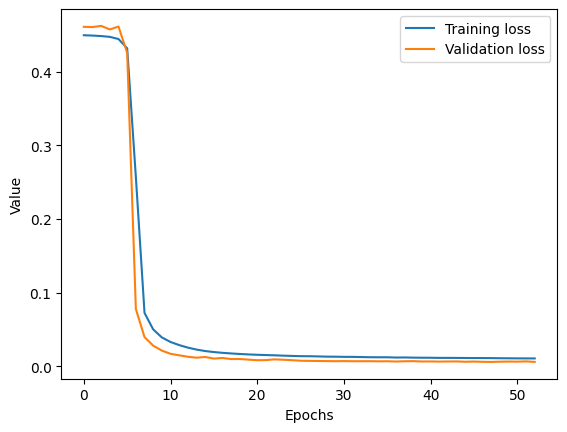

In [ ]:
# Plot the training and validation metrics
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

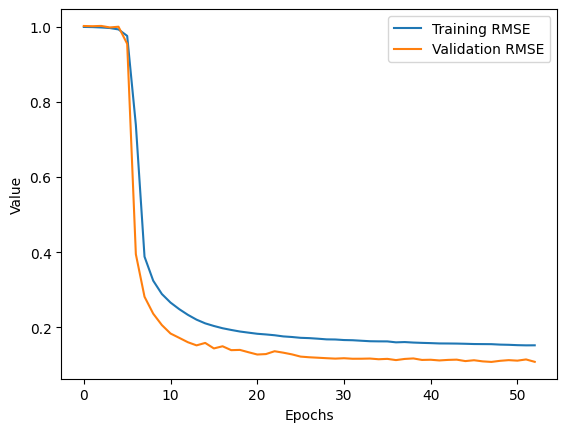

In [ ]:
plt.plot(history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

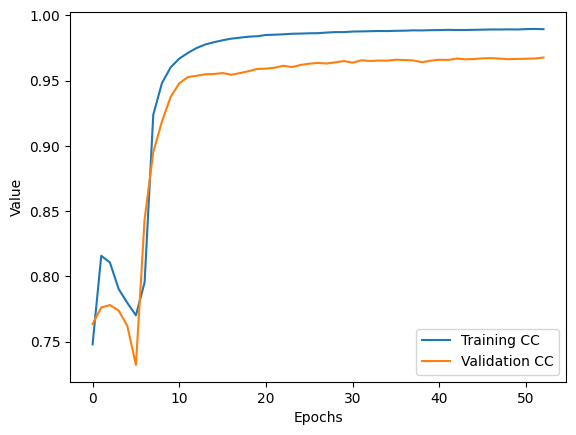

In [ ]:
plt.plot(history['cc'], label='Training CC')
plt.plot(history['val_cc'], label='Validation CC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

108/108 [==============================] - 4s 23ms/step


In [ ]:
y_pred.shape()

array([[-0.09911996],
       [-0.23598066],
       [-0.38841027],
       ...,
       [ 1.8339791 ],
       [ 1.5575895 ],
       [ 1.3432775 ]], dtype=float32)

In [12]:
X_test.shape

(3456, 48, 1)

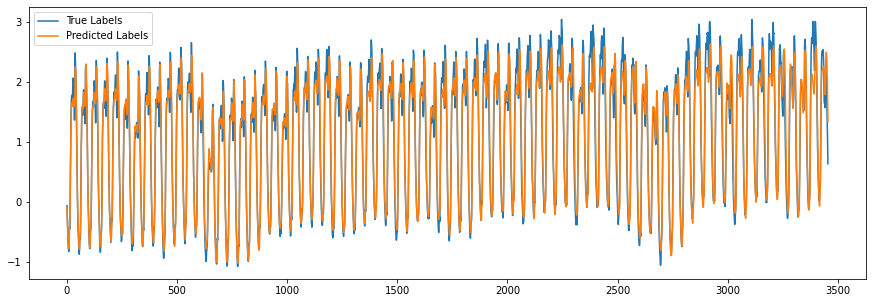

In [ ]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [ ]:
#Step 9
#Evaluate the model on the 1, 3, 7 Days to Forecast
X_one   = X_test[:48]
X_three = X_test[:144]
X_seven = X_test[:336]

y_one   = y_test[:48]
y_three = y_test[:144]
y_seven = y_test[:336]

print("1 Day to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_one, y_one)
y_pred_one = model.predict(X_one)


print("3 Days to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_three, y_three)
y_pred_three = model.predict(X_three)

print("7 Days to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_seven, y_seven)
y_pred_seven = model.predict(X_seven)

1 Day to Forecast
2/2 [==============================] - 1s 14ms/step
3 Days to Forecast
5/5 [==============================] - 0s 26ms/step
7 Days to Forecast
11/11 [==============================] - 0s 28ms/step


In [ ]:
#Step 10
#Inverse from scaled data
inv_pred_one = scaler.inverse_transform(y_pred_one)
inv_one      = scaler.inverse_transform(y_one)

inv_pred_three = scaler.inverse_transform(y_pred_three)
inv_three      = scaler.inverse_transform(y_three)

inv_pred_seven = scaler.inverse_transform(y_pred_seven)
inv_seven      = scaler.inverse_transform(y_seven)

#Copy data date
viz_one   = one_day_date.copy()
viz_three = three_day_date.copy()
viz_seven = seven_day_date.copy()

#Join true and predicted data
viz_one['load_pred'] = inv_pred_one
viz_one['load_true'] = inv_one

viz_three['load_pred'] = inv_pred_three
viz_three['load_true'] = inv_three

viz_seven['load_pred'] = inv_pred_seven
viz_seven['load_true'] = inv_seven

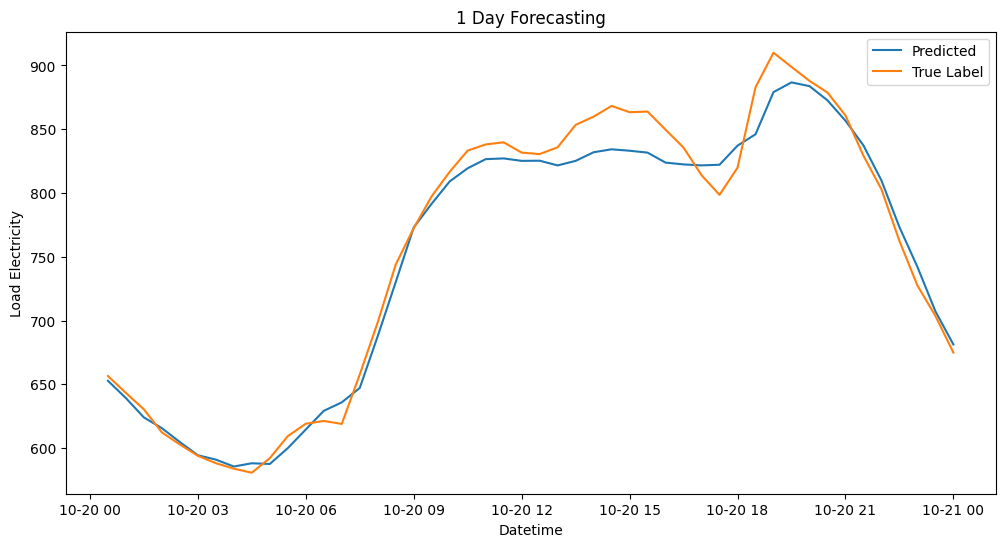

In [ ]:
#1 Day Forecasting

# Load dataset
viz_one = viz_one.set_index('datetime')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_one.index, viz_one['load_pred'], label='Predicted')
ax.plot(viz_one.index, viz_one['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Load Electricity')
ax.set_title('1 Day Forecasting')
ax.legend()

# Show plot
plt.show()


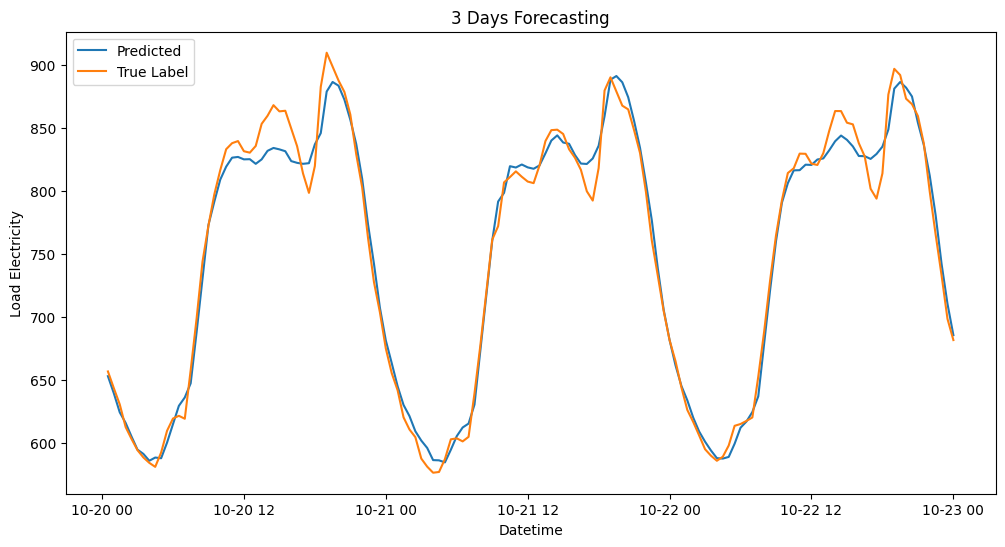

In [ ]:
#3 Days Forecasting

# Load dataset
viz_three = viz_three.set_index('datetime')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_three.index, viz_three['load_pred'], label='Predicted')
ax.plot(viz_three.index, viz_three['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Load Electricity')
ax.set_title('3 Days Forecasting')
ax.legend()

# Show plot
plt.show()


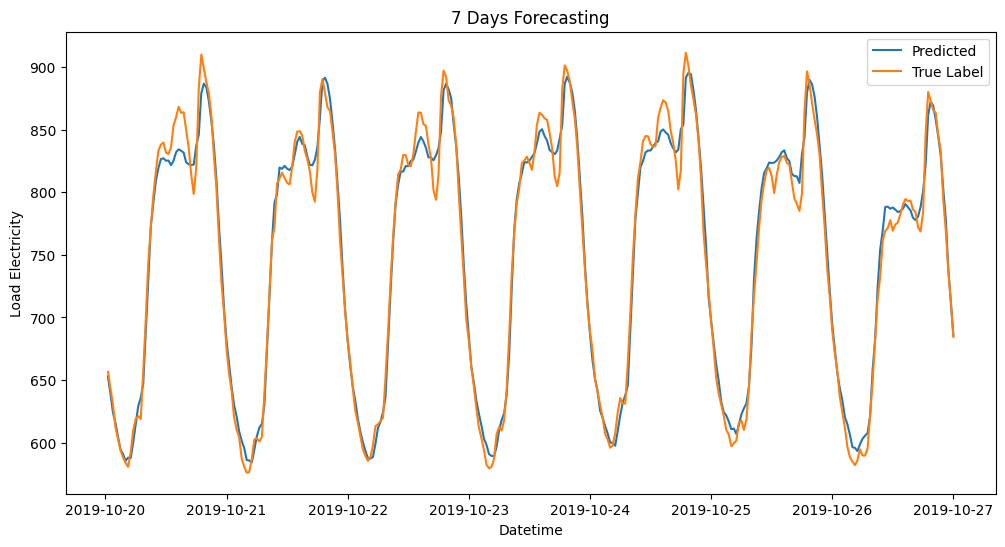

In [ ]:
#7 Days Forecasting

# Load dataset
viz_seven = viz_seven.set_index('datetime')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_seven.index, viz_seven['load_pred'], label='Predicted')
ax.plot(viz_seven.index, viz_seven['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Load Electricity')
ax.set_title('7 Days Forecasting')
ax.legend()

# Show plot
plt.show()


In [ ]:
import pickle

# Save the trained model
model.save('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Final.h5')

# Save the history object
with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Final.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 128)              33792     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37,953
Trainable params: 37,953
Non-trainable params: 0
_________________________________________________________________


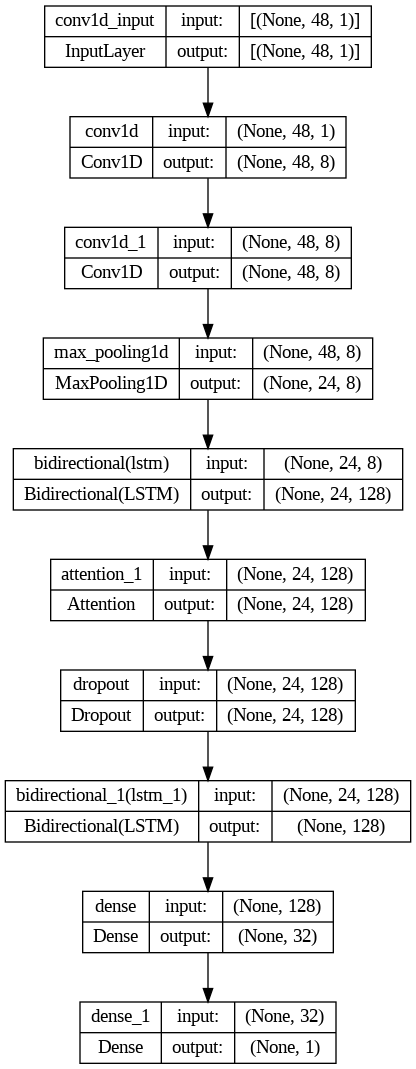

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Use Model To Forecasting

Load Library, Model, and Addition First

In [38]:
#1. Merge array data for base predict
x_data = np.vstack((X_train, X_val, X_test))
x_data

array([[[-1.08440691],
        [-1.17490414],
        [-1.2865174 ],
        ...,
        [-0.36847326],
        [-0.64700363],
        [-0.93558924]],

       [[-1.17490414],
        [-1.2865174 ],
        [-1.41924667],
        ...,
        [-0.64700363],
        [-0.93558924],
        [-1.13870525]],

       [[-1.2865174 ],
        [-1.41924667],
        [-1.67062787],
        ...,
        [-0.93558924],
        [-1.13870525],
        [-1.20808646]],

       ...,

       [[ 1.75489344],
        [ 1.45223048],
        [ 1.23443381],
        ...,
        [ 1.69928792],
        [ 1.45967136],
        [ 1.26158298]],

       [[ 1.45223048],
        [ 1.23443381],
        [ 0.9075377 ],
        ...,
        [ 1.45967136],
        [ 1.26158298],
        [ 1.11015094]],

       [[ 1.23443381],
        [ 0.9075377 ],
        [ 0.72754876],
        ...,
        [ 1.26158298],
        [ 1.11015094],
        [ 0.91407361]]])

In [39]:
len(val_data)

3504

In [40]:
x_data.shape

(34896, 48, 1)

In [41]:
#2. test model prediction
import numpy as np

# Set the window size and n_steps
n_steps = 48*7 # 7 days

# Get the last window_size data points
start_index = len(x_data) - n_steps
n_step = x_data[start_index:]

# Make the predictions
y_pred = model.predict(n_step)

# Print the predicted values
print(y_pred)

11/11 [==============================] - 1s 61ms/step
[[ 1.05079579e+00]
 [ 8.14539075e-01]
 [ 6.31460905e-01]
 [ 4.52420920e-01]
 [ 3.40017289e-01]
 [ 2.40186244e-01]
 [ 1.55164093e-01]
 [ 8.50546062e-02]
 [ 4.67057526e-02]
 [-1.66419148e-03]
 [ 4.84454632e-03]
 [ 8.24547410e-02]
 [ 1.10481650e-01]
 [ 1.85771853e-01]
 [ 3.29542726e-01]
 [ 8.00710082e-01]
 [ 1.23421383e+00]
 [ 1.54620600e+00]
 [ 1.78431249e+00]
 [ 1.90355229e+00]
 [ 1.96659923e+00]
 [ 1.99022579e+00]
 [ 1.97815776e+00]
 [ 1.99661708e+00]
 [ 2.00027728e+00]
 [ 2.05373621e+00]
 [ 2.05875087e+00]
 [ 2.08881021e+00]
 [ 2.06571627e+00]
 [ 2.05708027e+00]
 [ 2.00783324e+00]
 [ 1.96545219e+00]
 [ 1.91822815e+00]
 [ 1.91879153e+00]
 [ 1.96093202e+00]
 [ 2.02870464e+00]
 [ 2.17826319e+00]
 [ 2.34357095e+00]
 [ 2.47989202e+00]
 [ 2.53403449e+00]
 [ 2.57148051e+00]
 [ 2.58713841e+00]
 [ 2.55701256e+00]
 [ 2.46942568e+00]
 [ 2.31683278e+00]
 [ 2.06578779e+00]
 [ 1.81555247e+00]
 [ 1.56413186e+00]
 [ 1.24590874e+00]
 [ 9.92651939e-

In [42]:
#3. Invers to original data
inv_data = scaler.inverse_transform(y_pred)
inv_data

array([[767.1471 ],
       [743.65125],
       [725.44403],
       [707.63837],
       [696.4598 ],
       [686.53156],
       [678.07605],
       [671.1036 ],
       [667.2898 ],
       [662.4794 ],
       [663.12665],
       [670.84503],
       [673.6323 ],
       [681.12   ],
       [695.4181 ],
       [742.27594],
       [785.3881 ],
       [816.4159 ],
       [840.09576],
       [851.9542 ],
       [858.22424],
       [860.5739 ],
       [859.3738 ],
       [861.20953],
       [861.57355],
       [866.8901 ],
       [867.3888 ],
       [870.37823],
       [868.0815 ],
       [867.22266],
       [862.325  ],
       [858.11017],
       [853.41376],
       [853.4698 ],
       [857.66064],
       [864.4007 ],
       [879.27435],
       [895.7143 ],
       [909.27155],
       [914.656  ],
       [918.38007],
       [919.93726],
       [916.9412 ],
       [908.23065],
       [893.0552 ],
       [868.0886 ],
       [843.2026 ],
       [818.19867],
       [786.5512 ],
       [761.3647 ],


In [43]:
#4. Copy Dataframe
viz = df.copy()
viz

,datetime,load
0,2018-01-01 00:30:00,554.80
1,2018-01-01 01:00:00,545.80
2,2018-01-01 01:30:00,534.70
3,2018-01-01 02:00:00,521.50
4,2018-01-01 02:30:00,496.50
...,...,...
35035,2019-12-31 22:00:00,807.81
35036,2019-12-31 22:30:00,788.11
35037,2019-12-31 23:00:00,773.05
35038,2019-12-31 23:30:00,753.55


In [46]:
#5. Generate new forecasting date
from prophet import Prophet
m = Prophet()

viz = viz.rename(columns={'datetime': 'ds', 'load' : 'y'})

m.fit(viz)
future = m.make_future_dataframe(periods=n_steps, freq='30 min', include_history=False)
future

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznctfrx6/x_436yrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznctfrx6/a0p_9mp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77041', 'data', 'file=/tmp/tmpznctfrx6/x_436yrq.json', 'init=/tmp/tmpznctfrx6/a0p_9mp3.json', 'output', 'file=/tmp/tmpznctfrx6/prophet_modelayokuaci/prophet_model-20230413055130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:51:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:52:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2020-01-01 00:30:00
1,2020-01-01 01:00:00
2,2020-01-01 01:30:00
3,2020-01-01 02:00:00
4,2020-01-01 02:30:00
...,...
331,2020-01-07 22:00:00
332,2020-01-07 22:30:00
333,2020-01-07 23:00:00
334,2020-01-07 23:30:00


In [47]:
#6. Merge Forecasting Date and Data
future['load'] = inv_data
future = future.rename(columns={'ds': 'datetime'})
future

,datetime,load
0,2020-01-01 00:30:00,767.147095
1,2020-01-01 01:00:00,743.651245
2,2020-01-01 01:30:00,725.444031
3,2020-01-01 02:00:00,707.638367
4,2020-01-01 02:30:00,696.459778
...,...,...
331,2020-01-07 22:00:00,889.897522
332,2020-01-07 22:30:00,869.919678
333,2020-01-07 23:00:00,845.035095
334,2020-01-07 23:30:00,817.547974


In [48]:
#7. Copy historical data for Visualization
history_predict = n_steps #Set by window_size, 48 = 1 Day

hist_data = df.copy()
hist_data

start_index = len(hist_data) - history_predict
hist_data = hist_data[start_index:]

In [49]:
len(hist_data)

336

In [50]:
hist_data.tail(50)

,datetime,load
34990,2019-12-30 23:30:00,807.07
34991,2019-12-31 00:00:00,785.41
34992,2019-12-31 00:30:00,752.90
34993,2019-12-31 01:00:00,735.00
34994,2019-12-31 01:30:00,718.11
34995,2019-12-31 02:00:00,706.46
34996,2019-12-31 02:30:00,692.98
34997,2019-12-31 03:00:00,677.04
34998,2019-12-31 03:30:00,669.84
34999,2019-12-31 04:00:00,664.78


In [51]:
#8. Set Index
hist_data = hist_data.set_index('datetime')
future_data = future.set_index('datetime')

In [52]:
future_data

,load
datetime,
2020-01-01 00:30:00,767.147095
2020-01-01 01:00:00,743.651245
2020-01-01 01:30:00,725.444031
2020-01-01 02:00:00,707.638367
2020-01-01 02:30:00,696.459778
...,...
2020-01-07 22:00:00,889.897522
2020-01-07 22:30:00,869.919678
2020-01-07 23:00:00,845.035095


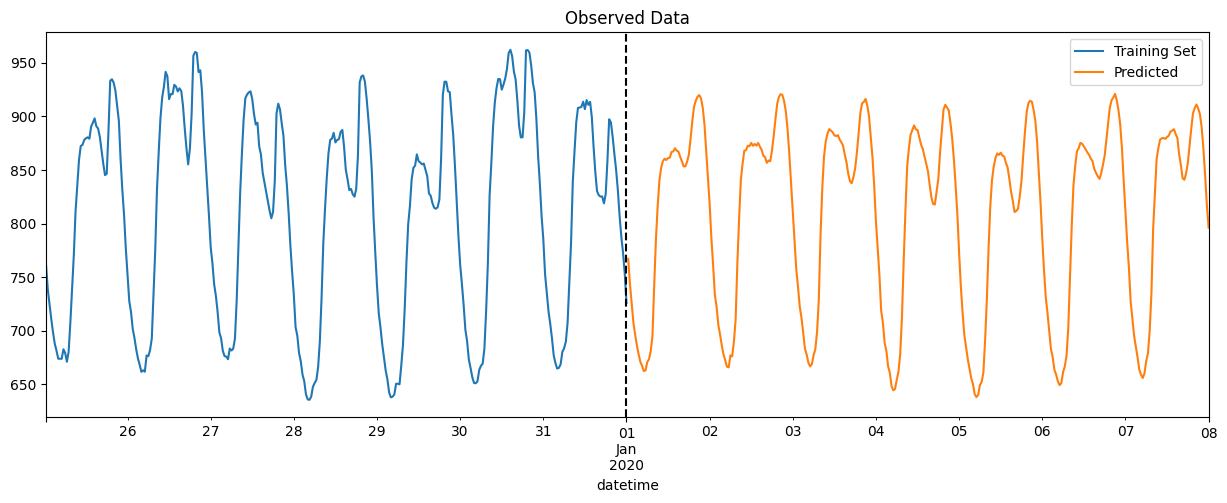

In [53]:
#9. Visualization

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
hist_data.plot(ax=ax, label='Training Data', title='Observed Data')
future_data.plot(ax=ax, label='Predicted')
ax.axvline('2020-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Predicted'])
plt.show()